# Introduction to Deep Learning with pytorch
## 1 - Live Coding pytorch: Fashion MNIST
### Import

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.autograd import Variable
from torchvision import datasets, transforms

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

/home/thytu/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


### Downloading Fashion MNIST

In [2]:
train_set = torchvision.datasets.FashionMNIST(
  root="./data/FashionMNIST",
  train=True,
  download=True,
  transform=transforms.Compose([
    transforms.ToTensor()
  ])
)

test_set = torchvision.datasets.FashionMNIST(
  root="./data/FashionMNIST",
  train=False,
  download=True,
  transform=transforms.Compose([
    transforms.ToTensor()
  ])
)

### Setting the data loaders

In [3]:
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

TRAINING_SIZE = len(iter(train_loader)) * BATCH_SIZE
TESTING_SIZE = len(iter(test_loader)) * BATCH_SIZE

### Displaying sample

<ipython-input-4-3abee7b8b563>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


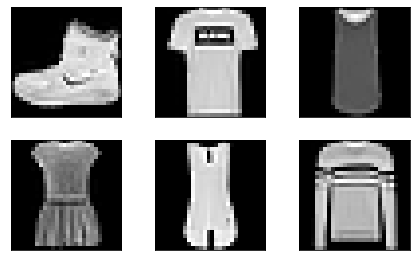

In [4]:
fig = plt.figure()

for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(train_set[i][0].reshape(28, 28, 1), cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])

fig.show()

### Creating Network

#### CNN output size formula
- we have an $Nh * Nw$ input
- we have an $Fh * Fw$ filter
- we have a padding $p$
- we have a filter $f$
- we have an output size $O$

### $Oh = \frac{Nh - Fh +2p}{s} + 1$
### $Ow = \frac{Nw - Fw +2p}{s} + 1$

In [5]:
class Network(nn.Module):
  def __init__(self):
    super().__init__()
    # kernel_size == size of the filter
    # out_channels == number of filters
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
    
    self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=10)
    
  def forward(self, t):
    t = self.conv1(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)
    
    t = self.conv2(t)
    t = F.relu(t)
    t = F.max_pool2d(t, kernel_size=2, stride=2)

    t = t.reshape(-1, 12 * 4 * 4) # the 4 * 4 is the height and width of the input channel
    t = self.fc1(t)
    t = F.relu(t)
    
    t = self.fc2(t)
    t = F.relu(t)
    
    t = self.out(t)
    # t = F.softmax(t, dim=1) with Cross Entropy loss function don't need softmax beacause LCE already do it
    
    return t
    

### Getting shape of our image after convolutions

In [6]:
conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

image, _ = next(iter(train_loader))

print(f"Before Conv: {image.size()}")
image = conv1(image)
image = F.max_pool2d(image, kernel_size=2, stride=2)
image = conv2(image)
image = F.max_pool2d(image, kernel_size=2, stride=2)
print(f"After Conv: {image.size()}")

Before Conv: torch.Size([64, 1, 28, 28])
After Conv: torch.Size([64, 12, 4, 4])


### Setting up our parameters

In [7]:
network = Network().to(device)

EPOCHS = 3
LEARNING_RATE = 0.001

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE)
optimizer = optim.Adam(network.parameters(), lr=LEARNING_RATE)

training_accuracies = []
testing_accuracies = []

### Function to get our accuracy

In [8]:
def get_num_correct(preds, labels):
  return preds.argmax(dim=1).eq(labels).sum().item()

### Training function

In [9]:
def train():
  network.train()
  correct_in_episode = 0
  episode_loss = 0
  
  for batch in train_loader:
    images, labels = batch

    predictions = network(images)
    loss = F.cross_entropy(predictions, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    episode_loss += loss.item()
    correct_in_episode += get_num_correct(predictions, labels)

  training_accuracies.append(correct_in_episode * 100 / TRAINING_SIZE)
  print(f"Epoch: {epoch + 1} accuracy: {correct_in_episode * 100 / TRAINING_SIZE:.2f}", end="\t")

### Testing function

In [10]:
def test():
  network.eval()
  episode_loss = 0
  correct_in_episode = 0
  
  with torch.no_grad():
    for batch in test_loader:
      images, labels = batch

      predictions = network(images)
      loss = F.cross_entropy(predictions, labels)

      episode_loss = loss.item()
      correct_in_episode += get_num_correct(predictions, labels)

  testing_accuracies.append(correct_in_episode * 100 / TESTING_SIZE)
  print(f'Validation: Accuracy: {correct_in_episode * 100 / TESTING_SIZE:.2f}')

### Running our model

In [11]:
for epoch in range(EPOCHS):
  train()
  test()

Epoch: 1 accuracy: 71.57	Validation: Accuracy: 78.23
Epoch: 2 accuracy: 81.52	Validation: Accuracy: 81.82
Epoch: 3 accuracy: 84.57	Validation: Accuracy: 83.12


### Displaying evolution of our accuracy

Text(0, 0.5, 'Accuracy')

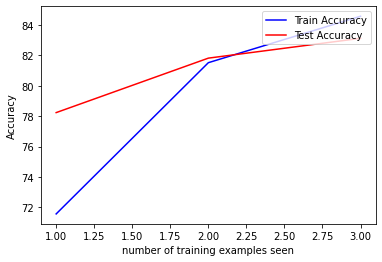

In [12]:
fig = plt.figure()

plt.plot(list(range(1, len(training_accuracies)+1)), training_accuracies, color='blue')
plt.plot(list(range(1, len(testing_accuracies)+1)), testing_accuracies, color='red')

plt.legend(['Train Accuracy', 'Test Accuracy'], loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')